# Nilsson shell model 


In [1]:
# Libraries

import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import sympy
from sympy.physics.quantum.cg import CG

In [2]:
# Constants

hbar = 6.582119569*10**(-22)           # MeV*s
c = 2.99792458*10**(8)*10**(15)        # fm/s
m_p = 938.27/c**2                      # MeV*s²/fm²
m_n = 939.57/c**2                      # MeV*s²/fm²
mu_n = [0.000,0.000,0.000,0.250,0.390,0.430,0.340,0.260,0.260]   # Values of modifyed oscillator parameters 
ka_n = [0.120,0.120,0.105,0.090,0.070,0.062,0.062,0.062,0.062]   # from N = 0,1,2,3,4,5,6,7,8
mu_p = [0.000,0.000,0.000,0.300,0.570,0.650,0.690,0.690,0.600] 
ka_p = [0.120,0.120,0.105,0.090,0.065,0.060,0.054,0.054,0.054]

def hbaromega(A, e):                          # Parameters: A mass number of nucleus, e deformation parameter
    return (45*A**(-1/3) - 25*A**(-2/3))/(1-e**2/3-2*e**3/27)**(1/3)
    #return 41*A**(-1/3)

def b(m, A, e):                                # Parameters: m mass of nucleon, A mass number of nucleus
    return hbar/np.sqrt(m*hbaromega(A,e))

In [3]:
# Harmonic oscillator radial wavefunction

def psiHO(r, N, l, m, A, e):                 # Parameters: r coordinate, N shell quantum number
                                             #             l orbital angular momentum,
                                             #             m mass of nucleon, A mass number of nucleus
    n = int((N-l)/2)
    bv = b(m,A,e)
    norm = np.sqrt(2*scp.special.factorial(n)/(bv*scp.special.gamma(n+l+3/2)))
    
    return norm*(r/bv)**(l+1)*np.exp(-r**2/(2*bv**2))*scp.special.assoc_laguerre(r**2/bv**2, n, k = l+1/2)


def Integrand(r, N, l1, l2, m, A, e):            # Parameters: r coordinate, n1, n2 radial quantum numbers, 
                                                 #             l orbital angular momentum, N number of neutrons,
                                                 #             Z number of protons, part = 0 for proton and 
                                                 #             1 for neutron, j total angular momentum
    
    f1 = psiHO(r, N, l1, m, A, e)
    f2 = psiHO(r, N, l2, m, A, e)
    
    return r**2*f1*f2

## Matrix elements

In [4]:
# Matrix elements of rotationally symmetric Hamiltonian

def H_d(N, l1, lamb1, sig1, l2, lamb2, sig2, A, e, part):
    
    l = l1
    
    if l1 != l2:
        return 0
    
    elif lamb1 != lamb2 and sig1 != sig2:
        
        ka = globals()["ka_{0}".format(part)][N]
        
        if lamb1 == lamb2+1 and sig1 == sig2-1:
            
            return -1/2*np.sqrt((l-lamb2)*(l+lamb2+1))*2*ka*hbaromega(A, e)
            #return -1/2*np.sqrt((l-lamb2)*(l+lamb2+1))*2*ka

        if lamb1 == lamb2-1 and sig1 == sig2+1:
            
            return -1/2*np.sqrt((l+lamb2)*(l-lamb2+1))*2*ka*hbaromega(A, e)
            #return -1/2*np.sqrt((l+lamb2)*(l-lamb2+1))*2*ka

        else:
            return 0

    elif lamb1 == lamb2 and sig1 == sig2:
        
        ka = globals()["ka_{0}".format(part)][N]
        mu = globals()["mu_{0}".format(part)][N]
        
        if part=="n":
            return 1/2*hbaromega(A, e)*(N+3/2) - 2*ka*hbaromega(A, e)*lamb1*sig1 - ka*mu*hbaromega(A, e)*(l*(l+1)-N*(N+3)/2)
            #return 1/2*(N+3/2) - 2*ka*lamb1*sig1 - ka*mu*(l*(l+1)-N*(N+3)/2)

        ########## HOW TO ADD THE ELECTROSTATIC POTENTIAL OF A DEFORMED NUCLEUS ??? ###########
        
        if part=="p":
            return 1/2*hbaromega(A, e)*(N+3/2) - 2*ka*hbaromega(A, e)*lamb1*sig1 - ka*mu*hbaromega(A, e)*(l*(l+1)-N*(N+3)/2)
            #return 1/2*(N+3/2) - 2*ka*lamb1*sig1 - ka*mu*(l*(l+1)-N*(N+3)/2)

    else:
        return 0
    
# Matrix elements of epsilon dependent Hamiltonian

def H_e(N, l1, lamb1, sig1, l2, lamb2, sig2, A, e, part):
    
    if lamb1 != lamb2 or sig1 != sig2:
        
        return 0
    
    else:
        if part=="p":
            m = m_p
            
        if part=="n":
            m = m_n
            
        coeffs = float(CG(l2,lamb2,2,0,l1,lamb1).doit())*float(CG(l2,0,2,0,l1,0).doit())         
        integral = scp.integrate.quad(Integrand, 0, 200, args=(N,l1,l2,m,A,e))[0]          # Integral up to 200fm
                                                               
        return -2/3*e*hbaromega(A, e)*np.sqrt((2*l2+1)/(2*l1+1))*integral*coeffs
        #return -2/3*e*np.sqrt((2*l2+1)/(2*l1+1))*integral*coeffs

In [5]:
# Function to compute matrix elements

def MatrixElement(N, l1, lamb1, sig1, l2, lamb2, sig2, A, e, part):
    return H_d(N, l1, lamb1, sig1, l2, lamb2, sig2, A, e, part) + H_e(N, l1, lamb1, sig1, l2, lamb2, sig2, A, e, part)

In [6]:
# Function to compute the matrix

##################  SEVERAL OPTIMIZATIONS MIGHT BE IMPLEMNETED AS THE Ω DEGENERACY AND THE HERMITICITY OF H #####################

def Matrix(N,A,e,part):
    
    deg = (N+1)*(N+2)
    l = [i for i in range(N,-1,-2)]
    s = [1/2,-1/2]
    m_l = [j for j in range(l[0],-l[0]-1,-1)]
    states = [[i,j,k] for i in l for j in range(i,-i-1,-1) for k in s]

    globals()['M{0}'.format(N)] = np.zeros((deg,deg)) 
    
    for i in range(0, deg):                                            
        for j in range(0, deg):       
            
            globals()['M{0}'.format(N)][i][j] = MatrixElement(N, states[i][0], states[i][1], states[i][2], states[j][0], states[j][1], states[j][2], A, e, part)
    
    P, D = sympy.Matrix(globals()['M{0}'.format(N)]).diagonalize()    
    del globals()['M{0}'.format(N)] 
    
    return [float(D[i,i]) for i in range(0,deg)]

In [7]:
inter = 0.1

def epsilonEvaluator(N,A,part):
    
    e = np.linspace(-inter,inter,500)
    E = []
    
    for i in e:
        E.append(np.array(Matrix(N,A,i,part))/(hbaromega(A, i)))
        #E.append(np.array(Matrix(N,A,i,part)))

    return np.array(E)

In [14]:
A = 165
ES0 = epsilonEvaluator(0,A,"n")
ES1 = epsilonEvaluator(1,A,"n")
ES2 = epsilonEvaluator(2,A,"n")
ES3 = epsilonEvaluator(3,A,"n")
#ES4 = epsilonEvaluator(4,A,"n")
#ES5 = epsilonEvaluator(5,A,"n")

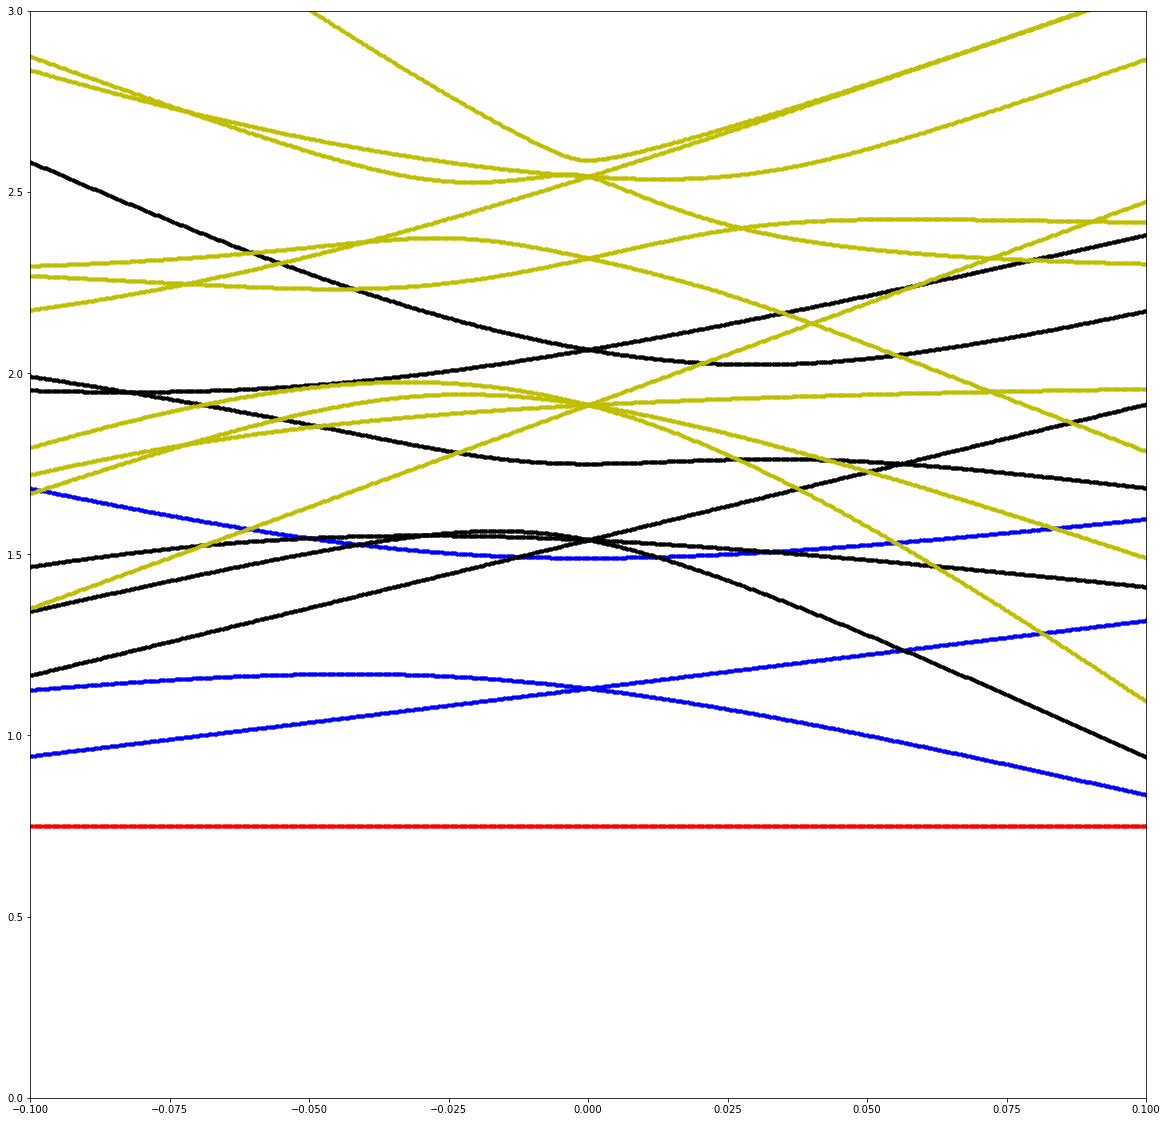

In [16]:
fig = plt.figure(figsize=(20,20))

for i in range(0,2):
    plt.plot(np.linspace(-inter,inter,500),ES0[:,i],".", c="r")
    
for i in range(0,6):
    plt.plot(np.linspace(-inter,inter,500),ES1[:,i],".", c="b")
    
for i in range(0,12):
    plt.plot(np.linspace(-inter,inter,500),ES2[:,i],".", c="k")
    
for i in range(0,20):
    plt.plot(np.linspace(-inter,inter,500),ES3[:,i],".", c="y")
    
#for i in range(0,30):
#    plt.plot(np.linspace(-inter,inter,500),ES4[:,i],".", c="o")
    
#for i in range(0,42):
#    plt.plot(np.linspace(-inter,inter,500),ES5[:,i],".", c="b")

plt.xlim(-inter,inter)
plt.ylim(0,3)
plt.show()

# References

- S. V. Nilsson and I. Ragnarsson, "Shapes and Shels in Nuclear Structure," Chapter 8.3, (1995), Cambridge University Press.